# Teste Técino - Estágio Data Engineer 

## Orientações
 

Nas tabelas anexas temos dados de diferentes origens sobre clientes fictícios de uma empresa de serviços financeiros:

* Base de transações de cartão de crédito: Cada linha mostra uma transação feita no cartão de crédito, com o valor, lugar onde foi feita a compra, quem fez a compra, data e o status (negada/aprovada)

* Base de perfil do cliente: cpf, nome, e-mail, sexo, idade, renda e estado de cada cliente

A partir dos dados oferecidos, faça uma apresentação em ppt ou pdf com sua análise dos dados respondendo às seguintes questões:

 

1. **Quantos clientes temos e qual o perfil demográfico da base?**

2. **Mostre a evolução do valor gasto por mês e aponte qual mês teve o maior gasto e verifique se algum estabelecimento se destacou.**

3. **Existem diferenças no comportamento de compras entre homens e mulheres?**

### Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import datetime as dt
import os

### Carregando os dois datasets

In [2]:
#Lendo o arquivo da base clientes
df_clientes = pd.read_csv('dados/base_clientes.csv', sep='\t')

In [3]:
df_clientes

,cpf,nome,sexo,idade,renda,estado,email
0,755077935,WELINTOM,masculino,30,14915,RS,welintom3@hotmail.com
1,338048902,CLEIDIOMAR,masculino,28,18322,SP,cleidiomar5@hotmail.com
2,7471498,AMANDIO,masculino,43,10177,TO,amandio8@hotmail.com
3,777780623,DECIVALDO,masculino,38,35864,RJ,decivaldo5@hotmail.com
4,574079717,GERALD,masculino,46,35234,MG,gerald5@hotmail.com
...,...,...,...,...,...,...,...
656,191349067,RAIMUDA,feminino,42,24014,RJ,raimuda4@hotmail.com
657,855387121,JACI,feminino,21,24211,RJ,jaci0@hotmail.com
658,763141734,QUINTINO,masculino,20,24139,TO,quintino3@hotmail.com
659,235053593,ANJO,masculino,47,37542,MG,anjo0@hotmail.com


In [25]:
#Lendo o arquivo da base transações
df_transacoes = pd.read_csv('dados/base_transacoes.csv', sep=';')

In [26]:
df_transacoes

,id_tran,cpf,estabelecimento,valor,status,data,Unnamed: 6
0,4137,902446808,cacau show,71,aprovada,Feb-20,NaN
1,244,264999401,cacau show,488,aprovada,Apr-20,NaN
2,1815,59310922,cacau show,427,aprovada,May-20,NaN
3,2142,178025312,cacau show,151,aprovada,Apr-20,NaN
4,555,693023755,cacau show,670,aprovada,Mar-20,NaN
...,...,...,...,...,...,...,...
5226,2837,976981026,zara plazasul,226,aprovada,Feb-20,NaN
5227,3190,260846826,zara plazasul,246,aprovada,Apr-20,NaN
5228,1447,763141734,zara plazasul,746,aprovada,Jan-20,NaN
5229,360,667968646,zara plazasul,202,aprovada,Mar-20,NaN


In [27]:
#Descartando a última coluna, que só possui valores nulos
df_transacoes = df_transacoes.drop(columns='Unnamed: 6')

### Modificando algumas colunas 

In [40]:
df_transacoes['data'] = pd.to_datetime(df_transacoes['data'], format='%b-%y')
df_transacoes['data'] = df_transacoes['data'].dt.date.apply(lambda x: x.strftime('%Y-%m'))

In [41]:
df_transacoes

,id_tran,cpf,estabelecimento,valor,status,data
0,4137,902446808,cacau show,71,aprovada,2020-02
1,244,264999401,cacau show,488,aprovada,2020-04
2,1815,59310922,cacau show,427,aprovada,2020-05
3,2142,178025312,cacau show,151,aprovada,2020-04
4,555,693023755,cacau show,670,aprovada,2020-03
...,...,...,...,...,...,...
5226,2837,976981026,zara plazasul,226,aprovada,2020-02
5227,3190,260846826,zara plazasul,246,aprovada,2020-04
5228,1447,763141734,zara plazasul,746,aprovada,2020-01
5229,360,667968646,zara plazasul,202,aprovada,2020-03


### Criando duas databases no SQL

In [30]:
#Criando uma nova conexão no banco de dados
conn = sqlite3.connect('startse.db')

#Verificando se a tabela já existe no banco de dados, e caso exista, descartando e criando uma nova
try: df_transacoes.to_sql('Transacoes', conn)
except Exception as e:
    if "Table 'Transacoes' already exists." in str(e):
        conn.cursor().execute('DROP TABLE Transacoes')
        df_transacoes.to_sql('Transacoes', conn)     
    else: raise e
        
try: df_clientes.to_sql('Clientes', conn)
except Exception as e:
    if "Table 'Clientes' already exists." in str(e):
        conn.cursor().execute('DROP TABLE Clientes')
        df_clientes.to_sql('Clientes', conn)     
    else: raise e        

### Questão 1:

In [31]:
query = "SELECT SUM(CASE WHEN sexo = 'masculino' THEN 1 ELSE 0 END) as Masculino, SUM(CASE WHEN sexo = 'feminino' THEN 1 ELSE 0 END) as Feminino, COUNT(*) as Total FROM Clientes"
df = pd.read_sql(query, conn)

In [32]:
df

,Masculino,Feminino,Total
0,367,294,661


**Temos 661 clientes no total, sendo 367 homens e 294 mulheres.**

**Descobrindo o perfil demográfico:**

## Sexo

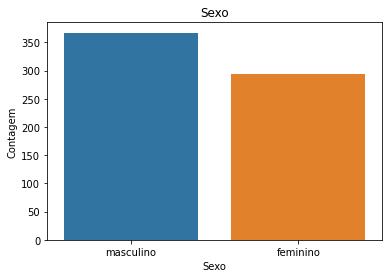

In [167]:
ax = sns.countplot(x='sexo', data=df_clientes)
plt.xlabel('Sexo')
plt.ylabel('Contagem')
plt.title('Sexo')
plt.show()

## Idade

In [164]:
query_idade = 'SELECT SUM(CASE WHEN idade BETWEEN 18 AND 24 THEN 1 ELSE 0 END) AS [18-24], SUM(CASE WHEN idade BETWEEN 25 AND 34 THEN 1 ELSE 0 END) AS [25-34],SUM(CASE WHEN idade BETWEEN 35 AND 44 THEN 1 ELSE 0 END) AS [35-44],SUM(CASE WHEN idade BETWEEN 45 AND 54 THEN 1 ELSE 0 END) AS [45-64],SUM(CASE WHEN idade BETWEEN 55 AND 64 THEN 1 ELSE 0 END) AS [55-64] FROM Clientes'
df_idade = pd.read_sql(query_idade, conn)
df_idade

,18-24,25-34,35-44,45-64,55-64
0,99,172,163,142,85


In [162]:
lista_y = [99, 172, 163, 142, 85]
lista_x = ['18-24', '25-34', '35-44', '45-64', '55-64']

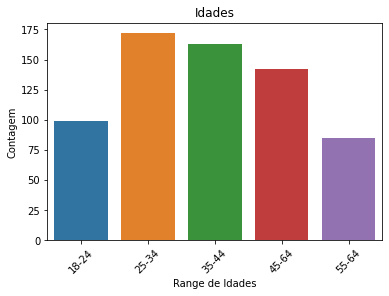

In [166]:
ax = sns.barplot(x=lista_x, y=lista_y)
plt.xticks(rotation=45)
plt.xlabel('Range de Idades')
plt.ylabel('Contagem')
plt.title('Idades')
plt.show()

## Renda

In [170]:
query_renda = 'SELECT SUM(CASE WHEN renda BETWEEN 10000 AND 15000 THEN 1 ELSE 0 END) AS [10-15], SUM(CASE WHEN renda BETWEEN 16000 AND 24000 THEN 1 ELSE 0 END) AS [16-24], SUM(CASE WHEN renda BETWEEN 25000 AND 36000 THEN 1 ELSE 0 END) AS [25-36], SUM(CASE WHEN renda BETWEEN 37000 AND 48000 THEN 1 ELSE 0 END) AS [37-48] FROM Clientes'
df_renda = pd.read_sql(query_renda, conn)
df_renda

,10-15,16-24,25-36,37-48
0,106,167,248,68


In [176]:
lista_x = ['10000-15000', '16000-24000', '25000-36000', '37000-48000']
lista_y = [106, 167, 248,  68]

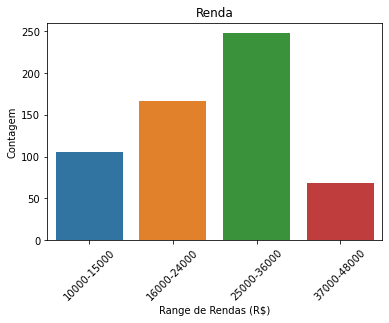

In [178]:
ax = sns.barplot(x=lista_x, y=lista_y)
plt.xticks(rotation=45)
plt.xlabel('Range de Rendas (R$)')
plt.ylabel('Contagem')
plt.title('Renda')
plt.show()

### Estado

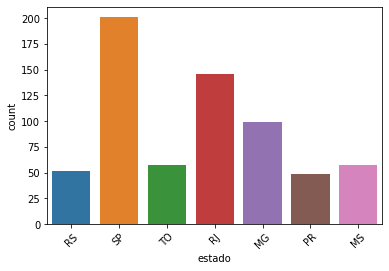

In [124]:
ax = sns.countplot(x='estado', data=df_clientes)
plt.xticks(rotation=45)
plt.show()

### Questão 2:

In [38]:
df_transacoes['estabelecimento'] = df_transacoes['estabelecimento'].str.lower()
#df_transacoes['data'] = pd.to_datetime(df_transacoes['data'])

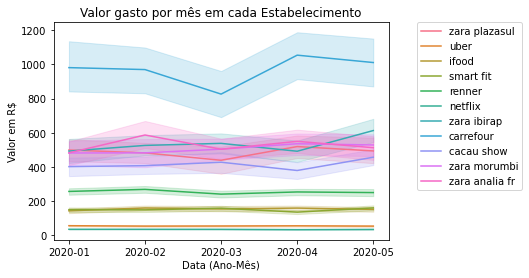

In [61]:
ax = sns.lineplot(x="data", y="valor", data=df_transacoes.sort_values(by="data"), hue='estabelecimento')
plt.title('Valor gasto por mês em cada Estabelecimento')
plt.ylabel('Valor em R$')
plt.xlabel('Data (Ano-Mês)')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
plt.show()

**A partir do gráfico acima, é possível dizer que o mês com o maior valor foi o de Abril, com um destaque para o Carrefour.**

### Questão 3:

In [63]:
query3 = 'SELECT * FROM Clientes LEFT JOIN Transacoes ON Clientes.cpf = Transacoes.cpf ' 
df3 = pd.read_sql(query3, conn)

In [88]:
df3['estabelecimento'] = df3['estabelecimento'].str.lower()

In [97]:
soma_valor_masculino = df3.loc[df3['sexo'] == 'masculino', 'valor'].sum()
print(f'O total gasto por homens é de: R${soma_valor_masculino}')

O total gasto por homens é de: R$915590


In [98]:
soma_valor_feminino = df3.loc[df3['sexo'] == 'feminino', 'valor'].sum()
print(f'O total gasto por mulheres é de: R${soma_valor_feminino}')

O total gasto por mulheres é de: R$736466


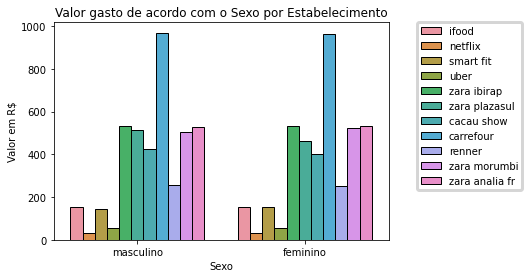

In [95]:
ax = sns.barplot(x="sexo", y="valor", data=df3, hue='estabelecimento', ci=None, edgecolor='black')
plt.title('Valor gasto de acordo com o Sexo por Estabelecimento')
plt.ylabel('Valor em R$')
plt.xlabel('Sexo')
plt.setp(ax.patches, linewidth=1)
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0)
plt.show()

**De acordo com o gráfico acima, podemos ver que não existe uma grande diferença comportamental de compras entre homens e mulheres.**